### Prerequisites & Initialize Workspace

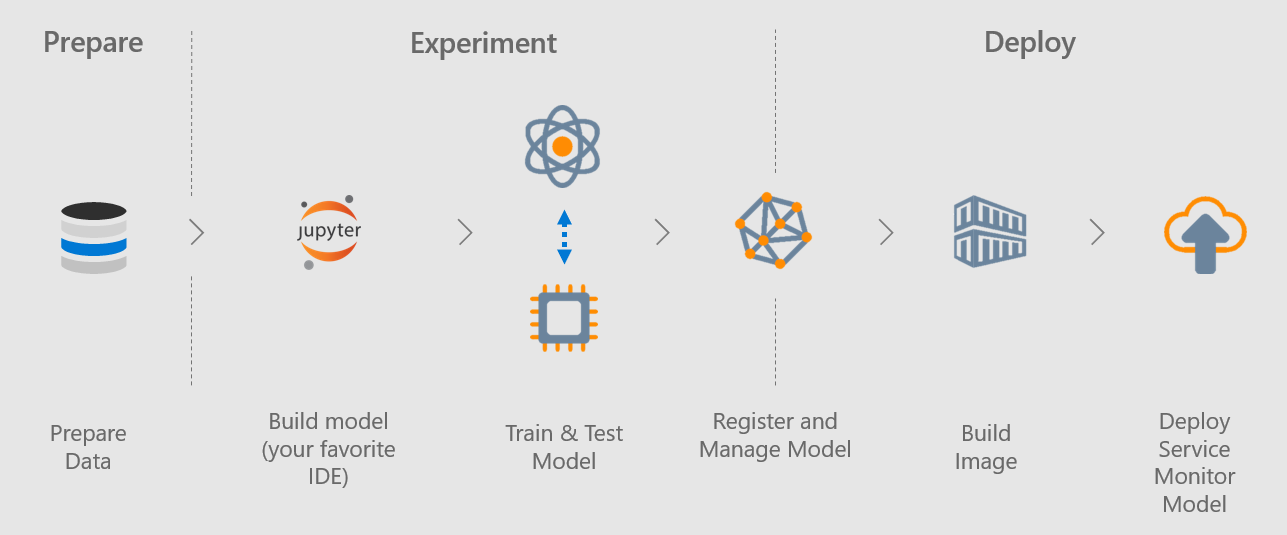

In [1]:
import azureml.core

print("SDK version:", azureml.core.VERSION)

/anaconda/envs/py36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


SDK version: 1.0.41


In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

yd-ml-service
yd-ds-rg
eastus2
779b3f2b-726d-430d-a1b7-f8c309b3bbd0


### Load the model
list exsiting models

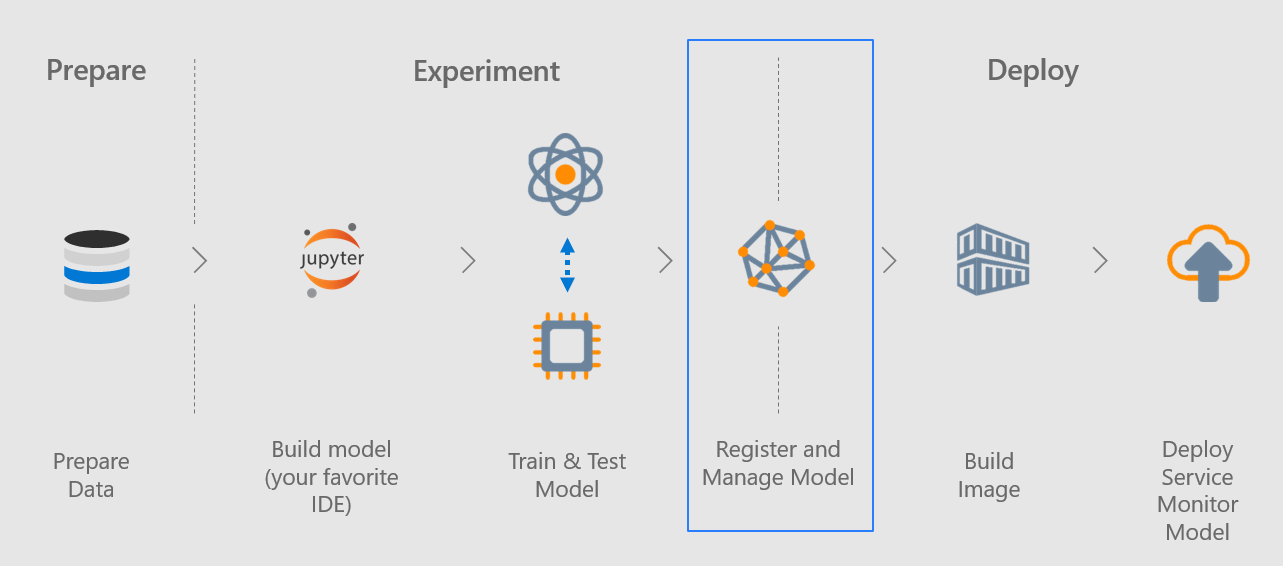

In [25]:
from azureml.core.model import Model
# models = Model.list(workspace=ws, name='Ibmattrition')
models = Model.list(workspace=ws)
for m in models:
    print("Name:", m.name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: attrion 	Version: 1 	Description: AutoML_5a6336ce-888e-4768-be1e-074af4cd2e3b_24_Model {}
Name: Ibmattrition 	Version: 1 	Description: AutoML_9df254a2-2da6-46a9-a2bf-0f8132e1b22d_24_Model {}
Name: pi_estimate 	Version: 1 	Description: None {}


In [26]:
the_model = Model.list(workspace=ws, name='attrion')

### Creating an Image

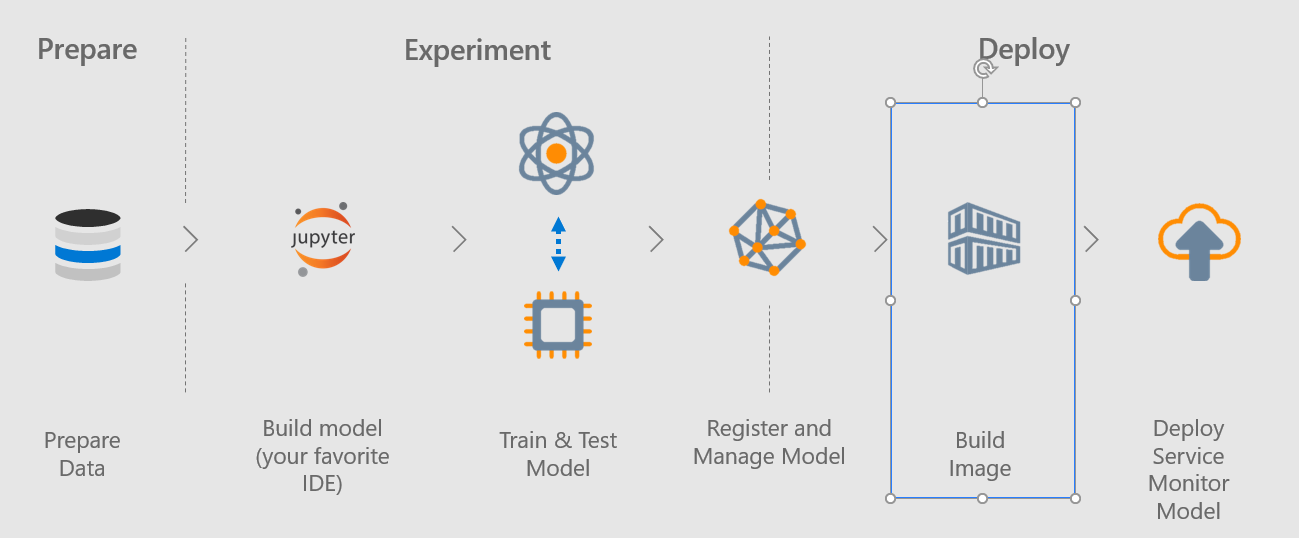

In [27]:
from azureml.core.image import Image, ContainerImage
image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="scoring.py",
                                 conda_file="condaEnv.yml",
                                 tags = {'area': "attrition", 'type': "classification"},
                                 description = "Image with employee attrition classification model")

image = Image.create(name = "ibmattr2",
                     # this is the model object. note you can pass in 0-n models via this list-type parameter
                     # in case you need to reference multiple models, or none at all, in your scoring script.
                     models = the_model,
                     image_config = image_config, 
                     workspace = ws)

Creating image


In [28]:
image.wait_for_creation(show_output = True)

Running................................

KeyboardInterrupt: 

In [4]:
from azureml.core.image import Image, ContainerImage
image  = Image(ws, name='employeeattr')

### Configure WevService deployment

In [5]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "attrition", 'type': "classification"}, 
                                               description = 'Predict employee attrition model')

### Deploy the webservice image to ACI

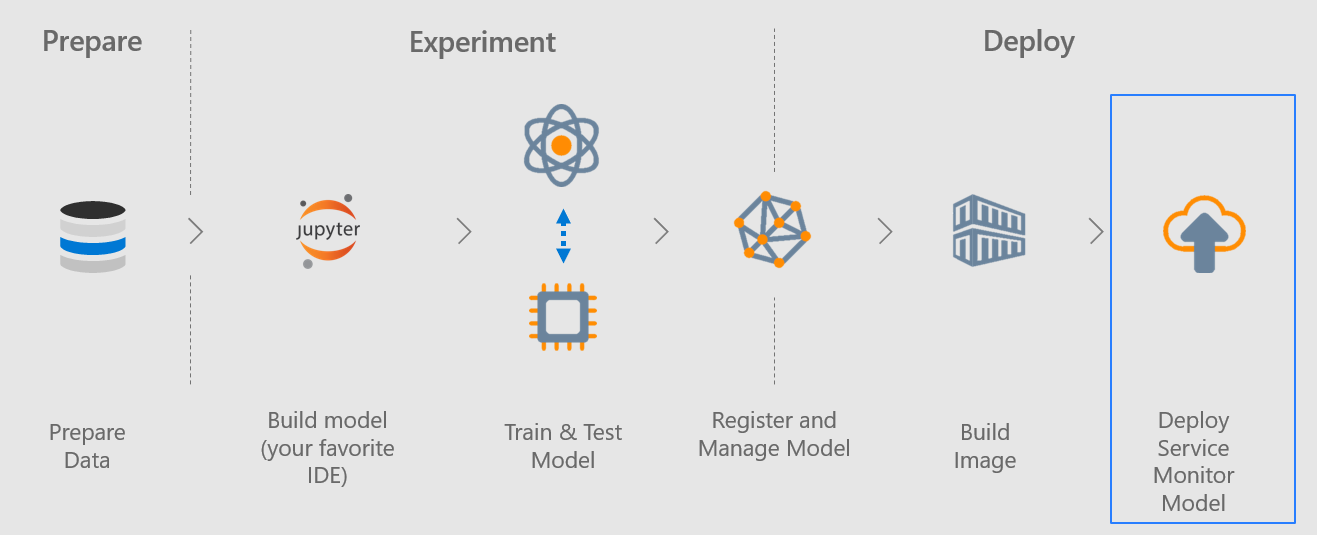

In [6]:
from azureml.core.webservice import Webservice

aci_service_name = 'my-aci-service-2'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

my-aci-service-2
Creating service
Running...........................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


In [7]:
print(aci_service.scoring_uri)

http://e3557e19-2bf2-446f-83c7-9bf18e951764.eastus.azurecontainer.io/score


### Test Data
4 examples which were not part of the training

No 56,'Non-Travel',667,'Research & Development',1,4,'Life Sciences',1,2026,3,'Male',57,3,2,'Healthcare Representative',3,'Divorced',6306,26236,1,'Y','No',21,4,1,80,1,13,2,2,13,12,1,9

Yes 29,'Travel_Rarely',1092,'Research & Development',1,4,'Medical',1,2027,1,'Male',36,3,1,'Research Scientist',4,'Married',4787,26124,9,'Y','Yes',14,3,2,80,3,4,3,4,2,2,2,2

No 42,'Travel_Rarely',300,'Research & Development',2,3,'Life Sciences',1,2031,1,'Male',56,3,5,'Manager',3,'Married',18880,17312,5,'Y','No',11,3,1,80,0,24,2,2,22,6,4,14

Yes 56,'Travel_Rarely',310,'Research & Development',7,2,'Technical Degree',1,2032,4,'Male',72,3,1,'Laboratory Technician',3,'Married',2339,3666,8,'Y','No',11,3,4,80,1,14,4,1,10,9,9,8


### Test web service
Call the web service with some dummy input data to get a prediction.

In [8]:
import json

test_sample = json.dumps({'data': [
    [56,'Non-Travel',667,'Research & Development',1,4,'Life Sciences',1,2026,3,'Male',57,3,2,'Healthcare Representative',3,'Divorced',6306,26236,1,'Y','No',21,4,1,80,1,13,2,2,13,12,1,9]
]})
test_sample = bytes(test_sample,encoding = 'utf8')

prediction = aci_service.run(input_data=test_sample)
print(prediction)

{"result": ["No"]}


### Delete ACI to clean up

In [9]:
aci_service.delete()